In this project we train a sequence to sequence neural network with attention mechanism to translate from Hindi to English. This project heavily draws from this [tutorial](https://https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) Their data selection and filtering methodology is immensely helpful, and allows us to focus more on the model architecture and easily going from problem formulation to the code.

For the hindi-english sentence pairs we use:
1.   Tatoeba Project (Downloaded from http://www.manythings.org/anki/)
2.   HindEnCorp 0.5 corpus (Downloaded from https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-625F-0).

The preprocessing steps for HindEnCorp0.5 to create an eng-hin.txt file in the sentence-pair style of the tatoeba datasets used in this notebook is provided as hindencorp-pre.ipynb in this repo.



In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

A one-hot vector is used to represent each eord in the chosen language. A unique index per word will be required later to denote the input and target words.

The helper class Lang has word2index and index2word dictionaries to help keep track of this, along with a count of each word to later help replace the rarer words.

In [0]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")


    print(lang1, lang2)
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(l.split('\t')[0]), l.split('\t')[1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
def filterPairs(pairs):
    return [pair for pair in pairs]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5

A sequence-to-sequence network consisting of an GRU/LSTM encoder and decoder is commonly used to perform machine translation. 
The encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The attention mechanism can be used to improve the existing model. Attention allows the decoder to learn to 'focus' on a specific parts of the encoder's outputs for every step of the decoder's outputs.

First, attention weights are calculated, which are then multiplied by the encoder output vectors to produce a weighted combination. The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.



In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

For training we use Cross Entropy Loss with stochastic gradient descent. 

Using the real target outputs as the next step input instead of the decoder's guess is known as “Teacher forcing” which helps the model learn better when used in judiciously.



In [0]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

For evaluation, we feed the decoder's predictions back to itself at each step because there are no explicit targets.

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # Change code for decoder here too
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
input_lang, output_lang, pairs = prepareData('eng', 'hin', True)
x = random.choice(pairs)
print(x[0])
print(x[1])

Reading lines...
eng hin
Read 2810 sentence pairs
Trimmed to 2810 sentence pairs
Counting words...
Counted words:
hin 3138
eng 2336
मुझे अपनी एक अटैची मिल नहीं रही है।
one of my bags is missing .


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)
evaluateRandomly(encoder1, decoder1)

2m 20s (- 32m 42s) (5000 6%) 4.2188
4m 39s (- 30m 13s) (10000 13%) 3.5171
6m 59s (- 27m 58s) (15000 20%) 2.8804
9m 20s (- 25m 41s) (20000 26%) 2.2460
11m 41s (- 23m 23s) (25000 33%) 1.7578
14m 3s (- 21m 5s) (30000 40%) 1.3251
16m 27s (- 18m 48s) (35000 46%) 1.0170
18m 51s (- 16m 29s) (40000 53%) 0.7182
21m 14s (- 14m 9s) (45000 60%) 0.4965
23m 39s (- 11m 49s) (50000 66%) 0.3297
26m 2s (- 9m 28s) (55000 73%) 0.2475
28m 27s (- 7m 6s) (60000 80%) 0.1626
30m 50s (- 4m 44s) (65000 86%) 0.1351
33m 14s (- 2m 22s) (70000 93%) 0.0969
35m 39s (- 0m 0s) (75000 100%) 0.0779
> उसकी मदद के बिना तुम नहीं कर पाते।
= if it had not been for her help you would never have done it .
< if it had not been for her help you would never have done it . <EOS>

> दो लड़के कमरे से भागे निकल आए।
= two boys came running out of the room .
< two boys came running out of the room . <EOS>

> स्कूल अप्रैल में शुरू होता है।
= school begins in april .
< school begins in april . <EOS>

> तुम अच्छे से सोये क्या?
= did you sle

input = हम वहाँ तीन बार खा चुके हैं।
output = we have eaten there three times . <EOS>


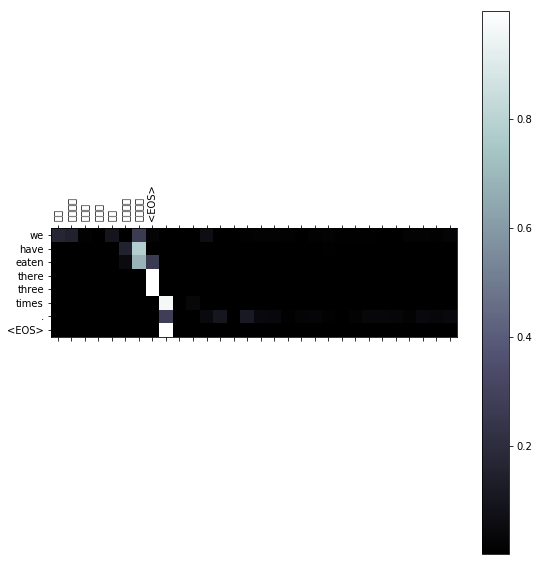

ValueError: ignored

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import numpy as np

def evaluateAndShowAttention(input_sentence):
  
    prop = font_manager.FontProperties(fname='data/Kruti_Dev_010.ttf')
    prop.set_weight = 'light'
    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.weight'] = 'light'
    
    output_words, attentions = evaluate(
        encoder1, decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    plt.show(attentions.numpy())
    
evaluateAndShowAttention('हम वहाँ तीन बार खा चुके हैं।')